# Imports

In [1]:
# ============================================================
# SETUP — Run this first!
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import os
import random
from sklearn.metrics import classification_report

# Verify versions
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version:      {np.__version__}")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU available: {gpus[0].name}")
else:
    print("\n⚠️  No GPU detected. Go to Runtime → Change runtime type → T4 GPU")

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

TensorFlow version: 2.20.0
NumPy version:      1.26.4

⚠️  No GPU detected. Go to Runtime → Change runtime type → T4 GPU


# 1. Data Exploration & PreProcessing

## 1.1 Load Data

In [2]:
train_dir = '../data/seg_train/seg_train'
test_dir = '../data/seg_test/seg_test'

print("Dataset structure:")
for root, dirs, files in os.walk('../data/'):
    level = root.replace('../data/', '').count(os.sep)
    indent = '  ' * level
    if level <= 2: # Keep output clean
        print(f"{indent}{os.path.basename(root)}/ ({len(files)} files)")

IMG_SIZE = 150  # Native resolution for Intel dataset
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical' # Use categorical for 6 classes
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Test set (separate folder)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print(f"\nClasses found: {class_names}")

Dataset structure:
/ (0 files)
seg_pred/ (0 files)
  seg_pred/ (7301 files)
seg_test/ (0 files)
  seg_test/ (0 files)
    buildings/ (437 files)
    forest/ (474 files)
    glacier/ (553 files)
    mountain/ (525 files)
    sea/ (510 files)
    street/ (501 files)
seg_train/ (0 files)
  seg_train/ (0 files)
    buildings/ (2191 files)
    forest/ (2271 files)
    glacier/ (2404 files)
    mountain/ (2512 files)
    sea/ (2274 files)
    street/ (2382 files)
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.

Classes found: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## 1.2 Visualize Sample

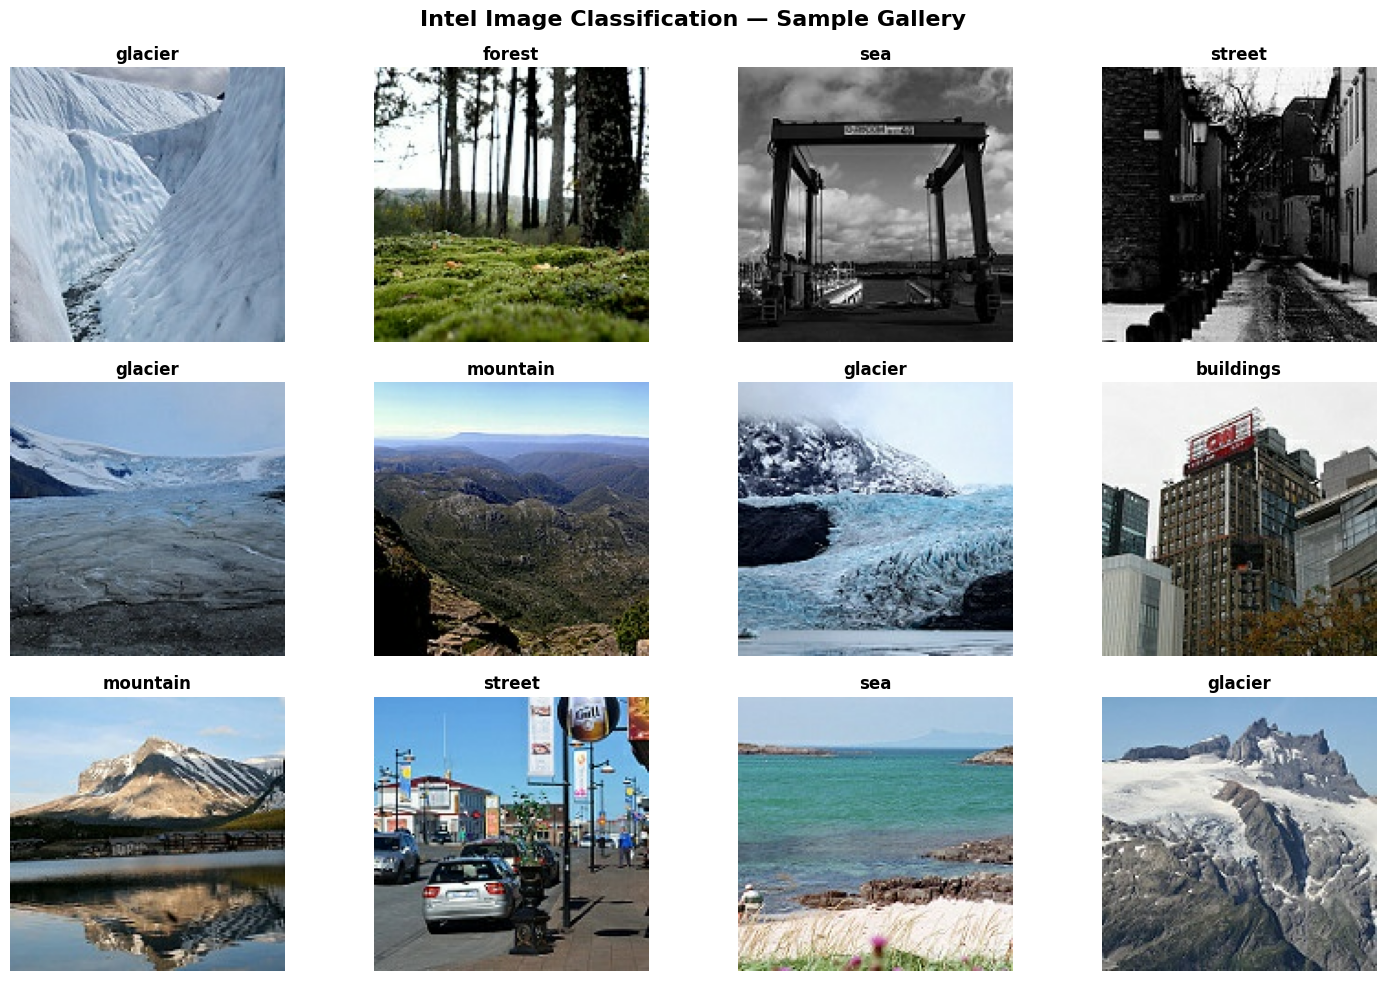

In [3]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(12): # Show 12 images
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        label_idx = np.argmax(labels[i])
        plt.title(class_names[label_idx], fontsize=12, fontweight='bold')
        plt.axis('off')

plt.suptitle('Intel Image Classification — Sample Gallery', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 1.3 Data Analysis

In [4]:
for images, labels in train_ds.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Pixel range: [{images.numpy().min():.0f}, {images.numpy().max():.0f}]")
    print(f"Flattened size: {150*150*3:,} features")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
print("Data pipeline optimized for training")

Batch shape: (32, 150, 150, 3)
Pixel range: [0, 255]
Flattened size: 67,500 features
Data pipeline optimized for training


# 2. Baseline CNN (No Augmentation)

In [5]:
def plot_training_curves(history, title='Model Training'):
    """Plot accuracy and loss curves for training and validation."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{title} — Accuracy', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0.4, 1.05])

    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{title} — Loss', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    print(f"\n📊 Final Results:")
    print(f"   Train Accuracy:      {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
    print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
    print(f"   Gap (overfit check): {gap:.4f} ({gap*100:.1f}%)")
    if gap > 0.15:
        print(f"   ⚠️  Large gap — model is OVERFITTING")
    elif gap > 0.05:
        print(f"   ⚡ Moderate gap — some overfitting")
    else:
        print(f"   ✅ Small gap — good generalization!")


def show_predictions(model, dataset, class_names, n=10):
    """Show model predictions on sample images for multi-class classification."""
    plt.figure(figsize=(16, 8)) # Increased height for 2 rows
    
    for images, labels in dataset.take(1):
        predictions = model.predict(images, verbose=0)
        
        for i in range(min(n, len(images))):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            pred_label = np.argmax(predictions[i])
            pred_prob = predictions[i][pred_label]
            
            true_label = np.argmax(labels[i])
            
            color = 'green' if pred_label == true_label else 'red'
            
            plt.title(f'Pred: {class_names[pred_label]}\n({pred_prob:.2f})\nTrue: {class_names[true_label]}',
                      fontsize=10, color=color, fontweight='bold')
            plt.axis('off')
            
    plt.suptitle('Intel Scene Predictions (Green=Correct, Red=Wrong)', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

In [6]:
model_intel = models.Sequential([
    # Rescaling layer (normalize pixels to 0-1)
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Classification head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # Note: 6 neurons for 6 classes, 'softmax' for multi-class probability
    layers.Dense(6, activation='softmax') 
])

# Display the architecture
model_intel.summary()
model_intel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(" Model compiled for Multi-class (6 classes)")

c:\Users\ERIC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

 Model compiled for Multi-class (6 classes)


Epoch 1/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 110s 291ms/step - accuracy: 0.6372 - loss: 0.9329 - val_accuracy: 0.7527 - val_loss: 0.7028
Epoch 2/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 285ms/step - accuracy: 0.7757 - loss: 0.6080 - val_accuracy: 0.8033 - val_loss: 0.5741
Epoch 3/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 98s 280ms/step - accuracy: 0.8244 - loss: 0.4787 - val_accuracy: 0.8022 - val_loss: 0.5718


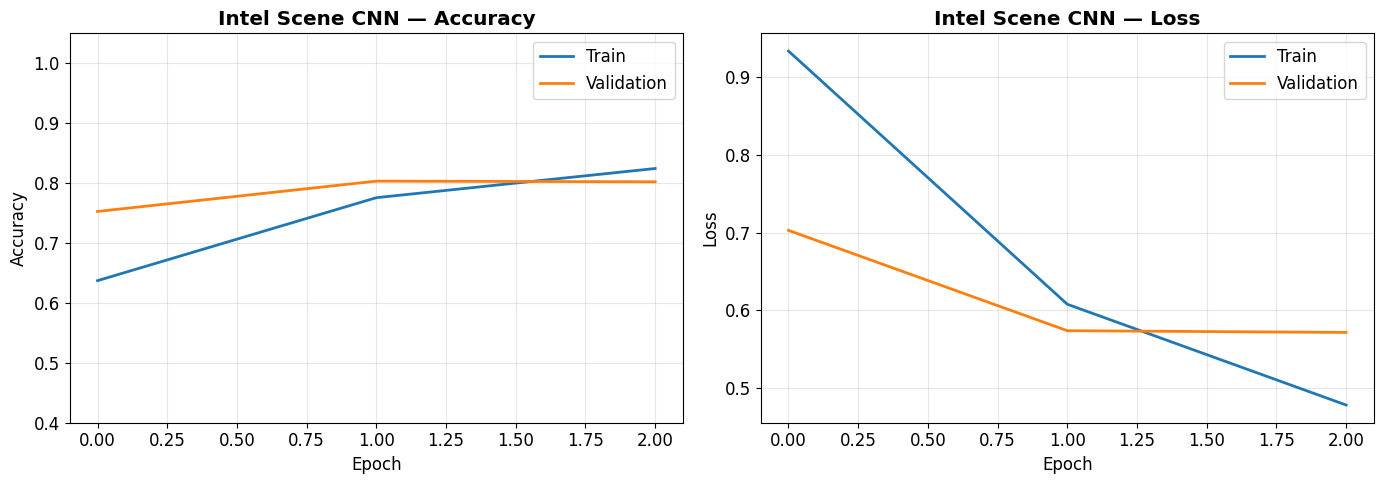


📊 Final Results:
   Train Accuracy:      0.8244 (82.4%)
   Validation Accuracy: 0.8022 (80.2%)
   Gap (overfit check): 0.0222 (2.2%)
   ✅ Small gap — good generalization!


In [7]:
EPOCHS = 3

history_intel = model_intel.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Plot training curves using your helper function
plot_training_curves(history_intel, title='Intel Scene CNN')

### Discussion
- Tried 50, 25, 15, 10, 5: They all overfit..
- Epoch 3 gave the good generalization


Detailed Classification Report:
              precision    recall  f1-score   support

   buildings       0.82      0.76      0.79       437
      forest       0.96      0.89      0.92       474
     glacier       0.73      0.84      0.79       553
    mountain       0.89      0.63      0.74       525
         sea       0.74      0.88      0.81       510
      street       0.79      0.87      0.83       501

    accuracy                           0.81      3000
   macro avg       0.82      0.81      0.81      3000
weighted avg       0.82      0.81      0.81      3000



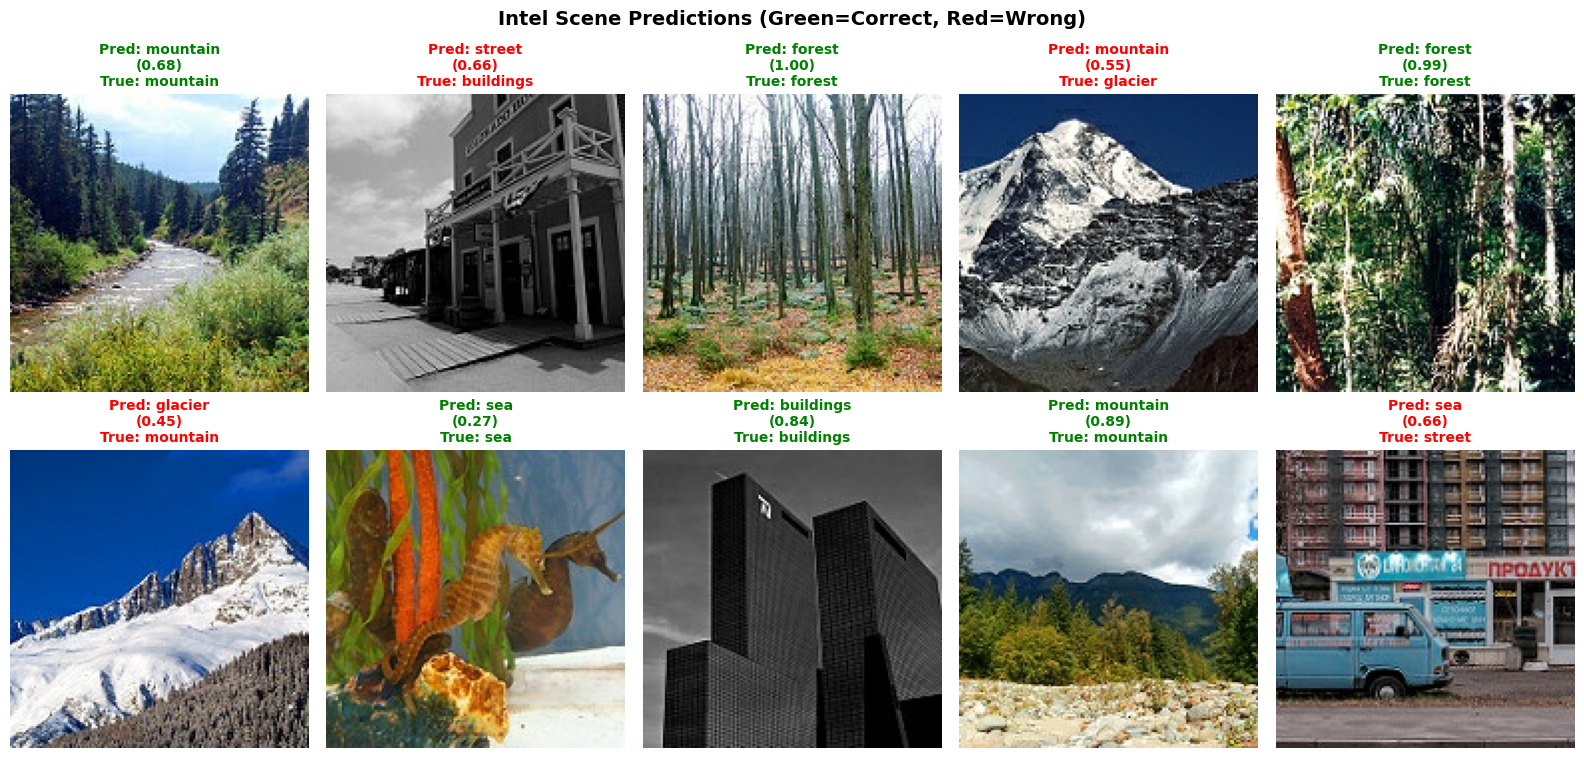

In [8]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model_intel.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Generate the report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Show predictions visually
show_predictions(model_intel, test_ds, class_names)

# 3. Improved CNN (With Augmentation)


In [10]:
inp = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = inp
conv_outputs = []
conv_names = []
for layer in model_intel.layers:
    x = layer(x)
    if isinstance(layer, layers.Conv2D):
        conv_outputs.append(x)
        conv_names.append(layer.name)
        print(f"  {layer.name}: output shape = {x.shape}")

feature_map_model = models.Model(inputs=inp, outputs=conv_outputs)


  conv2d: output shape = (None, 148, 148, 32)
  conv2d_1: output shape = (None, 72, 72, 64)
  conv2d_2: output shape = (None, 34, 34, 128)


In [11]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15), # 15% rotation range
    layers.RandomZoom(0.1),      # 10% zoom range
])

model_improved = models.Sequential([
    # Input & Augmentation
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,
    layers.Rescaling(1./255),

    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2), # Regularization

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3), # Regularization

    # Classification Head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # High dropout before final output
    layers.Dense(6, activation='softmax') # Multi-class output
])

# Compile for 6 classes
model_improved.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_improved.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,403,462 (20.61 MB)

 Trainable params: 5,403,014 (20.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
EPOCHS = 25

history_improved = model_improved.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Use your class helper function to plot results
plot_training_curves(history_improved, title='Improved CNN (Augmentation + Regularization)')

Epoch 1/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 250s 712ms/step - accuracy: 0.4387 - loss: 1.2761 - val_accuracy: 0.4961 - val_loss: 1.1144
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 255s 726ms/step - accuracy: 0.4383 - loss: 1.2785 - val_accuracy: 0.5214 - val_loss: 1.1284
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 252s 719ms/step - accuracy: 0.4526 - loss: 1.2404 - val_accuracy: 0.4979 - val_loss: 1.3018
Epoch 4/25
236/351 ━━━━━━━━━━━━━━━━━━━━ 1:21 707ms/step - accuracy: 0.4502 - loss: 1.2537

KeyboardInterrupt: 